-What about electrons? (I don't see any - 2 phys.me)

-1e11 and mDM?

-Compute T(E,z_in, z_dep) by doing a delta function injection

# Full Transfer Functions

In [18]:
%load_ext autoreload
import sys
sys.path.append("..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
%autoreload

import matplotlib
matplotlib.rc_file('matplotlibrc')
import matplotlib.pyplot as plt

%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [10,10]


from astropy.io import fits

import numpy as np
import copy
import pickle

import darkhistory.physics as phys
import darkhistory.utilities as utils
import darkhistory.spec.spectools as spectools
import darkhistory.spec.transferfunction as tf
import darkhistory.spec.transferfunclist as tflist
from darkhistory.spec.spectrum import Spectrum
from darkhistory.spec.spectra import Spectra
import darkhistory.history.tla as tla

from scipy.interpolate import interp1d

from tqdm import tqdm_notebook as tqdm

from darkhistory.electrons.ics.ics_spectrum import ics_spec
from darkhistory.electrons.ics.ics_engloss_spectrum import engloss_spec
from darkhistory.electrons.ics.ics_cooling import get_ics_cooling_tf

from darkhistory.low_energy.lowE_deposition import compute_fs

# np.set_printoptions(threshold=np.nan)

In [3]:
# mDM = 1e11
# sigmav = 1e-24

# def rate_func_swave(rs):
#     return 0*phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

# def test(rs, x1, x2, x3):
#     return 0.3

# test = tla.get_history(
#                 np.array([phys.TCMB(3000), 1, 0, 0]), 0.3, 0.3, 0.3, 
#                 rate_func_swave, np.flipud(np.arange(1, 3001)), reion_switch=False
#             )

# out = np.stack((np.flipud(np.arange(1, 3001)), test[:,0], test[:,1]))
# # pickle.dump(
# #     out, open("/Users/hongwan/GitHub/DarkHistory/darkhistory/history/std_soln.p", "wb")       
# #            )

In [4]:
soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
xe_std  = interp1d(soln[0,:], soln[2,:])
T_m_std = interp1d(soln[0,:], soln[1,:])

In [5]:
rs = 600
print(xe_std(rs))
print(T_m_std(rs)/phys.kB)
print(phys.TCMB(rs)/phys.kB)

0.0009648017275850074
1625.561215315584
1635.2995445551107


In [6]:
# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,0]/phys.kB)
# plt.plot(np.flipud(np.arange(1, 3001)), phys.TCMB(np.flipud(np.arange(1, 3001)))/phys.kB, 'k:')
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

# plt.figure()

# plt.plot(np.flipud(np.arange(1, 3001)), test[:,1])
# ax = plt.gca()

# ax.set_xscale('log')
# ax.set_yscale('log')

## Photon Transfer Functions

In [7]:
user = 'gridgway'

highengphot_tflist_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_photspec_60eV_complete_coarse.raw", "rb"))
lowengphot_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengphotspec_60eV_complete_coarse.raw", "rb"))
lowengelec_tflist_arr  = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/tfunclist_lowengelecspec_60eV_complete_coarse.raw", "rb"))
CMB_engloss_arr = pickle.load(open("/Users/"+user+"/Dropbox (MIT)/Photon Deposition/CMB_engloss_60eV_complete_coarse.raw", "rb"))

In [8]:
highengphot_tflist_arr[0]._grid_vals.shape

(51, 325, 500)

In [9]:
photeng = highengphot_tflist_arr[0].eng
eleceng = lowengelec_tflist_arr[0].eng

#Split photeng into high and low energy. 
photeng_high = photeng[photeng > 60]
photeng_low  = photeng[photeng <= 60]

# Split eleceng into high and low energy. 
eleceng_high = eleceng[eleceng > 3000]
eleceng_low  = eleceng[eleceng <= 3000]


for highengphot_tflist in highengphot_tflist_arr:
    
#     highengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)

    for tf in highengphot_tflist:
        # tf.rebin(photeng_high)
#         tf.rebin(photeng)
        
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size, 0), (0, 0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    highengphot_tflist._eng = photeng
    highengphot_tflist._in_eng = photeng
    highengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in highengphot_tflist._tflist])
    )
    
# lowengphot_tflist.in_eng set to photeng_high
for lowengphot_tflist in lowengphot_tflist_arr:
    
#     lowengphot_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengphot_tflist:
#         tf.rebin(photeng)
        # Pad with zeros so that it becomes photeng x photeng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        # Photons in the low energy bins should be immediately deposited.
        tf._grid_vals[0:photeng_low.size, 0:photeng_low.size] = np.identity(photeng_low.size)
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = photeng
        tf._rs = tf.rs[0]*np.ones_like(photeng)
    
    lowengphot_tflist._eng = photeng
    lowengphot_tflist._in_eng = photeng
    lowengphot_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengphot_tflist._tflist])
    )
    
# lowengelec_tflist.in_eng set to photeng_high 
for lowengelec_tflist in lowengelec_tflist_arr:
    
#     lowengelec_tflist.at_val('in_eng', photeng_high, bounds_error=False, fill_value=0)
    
    for tf in lowengelec_tflist:
#         tf.rebin(eleceng)
        # Pad with zeros so that it becomes photeng x eleceng. 
        tf._grid_vals = np.pad(tf.grid_vals, ((photeng_low.size,0), (0,0)), 'constant')
        tf._N_underflow = np.pad(tf._N_underflow, (photeng_low.size, 0), 'constant')
        tf._eng_underflow = np.pad(tf._eng_underflow, (photeng_low.size, 0), 'constant')
        tf._in_eng = photeng
        tf._eng = eleceng
        tf._rs = tf.rs[0]*np.ones_like(photeng)

    lowengelec_tflist._eng = eleceng
    lowengelec_tflist._in_eng = photeng
    lowengelec_tflist._grid_vals = np.atleast_3d(
        np.stack([tf.grid_vals for tf in lowengelec_tflist._tflist])
    )
    
    for engloss in CMB_engloss_arr:
        engloss = np.pad(engloss, ((0,0),(photeng_low.size, 0)), 'constant')


In [10]:
xes = 0.5 + 0.5*np.tanh([-5., -4.1, -3.2, -2.3, -1.4, -0.5, 0.4, 1.3, 2.2, 3.1, 4])


In [67]:
mDM = 1e11

highengphot_tf_interp = tflist.TransferFuncInterp(xes, highengphot_tflist_arr)
lowengphot_tf_interp = tflist.TransferFuncInterp(xes, lowengphot_tflist_arr)
lowengelec_tf_interp = tflist.TransferFuncInterp(xes, lowengelec_tflist_arr)


phot_spec_init = spectools.rebin_N_arr(np.array([1]), 
                                      np.array([mDM]), 
                                      photeng)
phot_spec_init.switch_spec_type()


In [68]:
print(phot_spec_init.toteng(bound_type = 'eng', bound_arr = np.array([1,1e13]))/mDM)

[1.]


In [76]:
%autoreload
phot_spec_init.rs = 3000
end_rs   = 100
#mDM = 1e8
sigmav = 1e-26
tau = 1e24

def rate_func_swave_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)/(2*mDM)

def rate_func_swave_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav)

def rate_func_decay_N(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)/mDM

def rate_func_decay_eng(rs):
    # This is dN/dV dt
    return phys.inj_rate('decay', rs, tau=tau)


def rate_func_swave_N_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)/(2*mDM)

def rate_func_swave_eng_2(rs):
    # This is dN/dV dt
    return phys.inj_rate('swave', rs, mDM=mDM, sigmav=sigmav*1e-30)


def evolve(
    in_spec_elec, in_spec_phot, 
    rate_func_N, rate_func_eng, xe_init, T_m_init,
    highengphot_tf_interp, lowengphot_tf_interp, 
    lowengelec_tf_interp, 
    end_rs, coarsen_factor=1, std_soln=False
):
    """
    Main function that computes the temperature and ionization history. 
    
    Parameters
    ----------
    in_spec_elec : Spectrum
        Spectrum per annihilation/decay into electrons. 
    in_spec_phot : Spectrum
        Spectrum per annihilation/decay into photons.
    rate_func_N : function
        Function describing the rate of annihilation/decay, dN/(dV dt)
    rate_func_eng : function
        Function describing the rate of annihilation/decay, dE/(dV dt)
    xe_init : float
        xe at the initial redshift. 
    T_m_init : float
        Matter temperature at the initial redshift. 
    highengphot_tf_interp : TransferFuncInterp
        Interpolation table for high energy photons. 
    lowengphot_tf_interp : TransferFuncInterp
        Interpolation table for low energy photons. 
    lowengelec_tf_interp : TransferFuncInterp
        Interpolation table for low energy electrons. 
    end_rs : float
        Final redshift to evolve to. 
    coarsen_factor : int
        Coarsening to apply to the transfer function matrix. 
    std_soln : bool
        If true, uses the standard TLA solution for f(z). 
    """
    
    # Initialize the next spectrum as None.
    next_highengphot_spec = None
    next_lowengphot_spec  = None
    next_lowengelec_spec  = None
    
    if (
        highengphot_tf_interp.dlnz    != lowengphot_tf_interp.dlnz
        or highengphot_tf_interp.dlnz != lowengelec_tf_interp.dlnz
        or lowengphot_tf_interp.dlnz  != lowengelec_tf_interp.dlnz
    ):
        raise TypeError('TransferFuncInterp objects must all have the same dlnz.')
    
    if in_spec_elec.rs != in_spec_phot.rs:
        raise TypeError('Input spectra must have the same rs.')
    
    # redshift/timestep related quantities. 
    dlnz = highengphot_tf_interp.dlnz
    prev_rs = None
    rs = in_spec_phot.rs
    dt = dlnz/phys.hubble(rs)
    
    # The initial input dN/dE per annihilation to per baryon per dlnz, 
    # based on the specified rate. 
    # dN/(dN_B d lnz dE) = dN/dE * (dN_ann/(dV dt)) * dV/dN_B * dt/dlogz
    
    # ICS for in_spec_elec goes here.
    
    # (Should this be multiplied by dlnz?)
    init_inj_spec = (
        in_spec_phot * rate_func_N(rs) * dt / (phys.nB * rs**3)
    )
    
    
    # Initialize the Spectra object that will contain all the 
    # output spectra during the evolution.
    out_highengphot_specs = Spectra([init_inj_spec], spec_type=init_inj_spec.spec_type)
    out_lowengphot_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    out_lowengelec_specs  = Spectra([], spec_type=init_inj_spec.spec_type)
    
    # Initialize the xe and T array that will store the solutions.
    xe_arr  = np.array([xe_init])
    T_m_arr = np.array([T_m_init])
    
    # Load the standard TLA solution if necessary. 
#     if std_soln:
    if True:
        soln = pickle.load(open("../darkhistory/history/std_soln.p", "rb"))
        xe_std  = interp1d(soln[0,:], soln[2,:])
        T_m_std = interp1d(soln[0,:], soln[1,:])

    # Define these methods for speed.
    append_highengphot_spec = out_highengphot_specs.append
    append_lowengphot_spec  = out_lowengphot_specs.append
    append_lowengelec_spec  = out_lowengelec_specs.append
    
    # Loop while we are still at a redshift above end_rs.
    while rs > end_rs:
        
        # If prev_rs exists, calculate xe and T_m. 
        if prev_rs is not None:
#             print('here at least?')
            
            # f_continuum, f_lyman, f_ionH, f_ionHe, f_heat
            # f_raw takes in dE/(dV dt)
            if std_soln:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
                print("\n SHOULD BE ONE: ", (next_lowengelec_spec.toteng() + next_lowengphot_spec.toteng())/(
                np.sum(f_raw) * rate_func_eng(rs) * dt / phys.nB / rs**3), '\n')
                
            else:
                f_raw = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
                
            std_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_std(rs), 0, 0]), rate_func_eng(rs), dt
                )
            
            backreaction_f = compute_fs(
                    next_lowengelec_spec, next_lowengphot_spec,
                    np.array([1-xe_arr[-1], 0, 0]), rate_func_eng(rs), dt
                )
            
            init_cond = np.array([T_m_arr[-1], xe_arr[-1], 0, 0])

            new_vals = tla.get_history(
                init_cond, f_raw[2], f_raw[1], f_raw[4], 
                rate_func_eng, np.array([prev_rs, rs]),
                reion_switch = False
            )

            T_m_arr = np.append(T_m_arr, new_vals[-1,0])
            xe_arr  = np.append(xe_arr,  new_vals[-1,1])
            
        print('T_m at '+str(rs)+': '+ str(T_m_arr[-1]))
        print('x_e at '+str(rs)+': '+ str(xe_arr[-1]))
        print('Standard x_e at '+str(rs)+': '+str(xe_std(rs)))
        if prev_rs is not None:
            print('Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', backreaction_f)
            print('Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat: ', std_f)
            
        if std_soln:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_std(rs))
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_std(rs))
        else:
            highengphot_tf = highengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengphot_tf  = lowengphot_tf_interp.get_tf(rs, xe_arr[-1])
            lowengelec_tf  = lowengelec_tf_interp.get_tf(rs, xe_arr[-1])
        
#         if coarsen_factor > 1:
#             prop_tf = np.zeros_like(highengphot_tf._grid_vals)
#             for i in np.arange(coarsen_factor):
#                 prop_tf += matrix_power(highengphot_tf._grid_vals, i)
#             lowengphot_tf._grid_vals = np.matmul(prop_tf, lowengphot_tf._grid_vals)
#             lowengelec_tf._grid_vals = np.matmul(prof_tf, lowengelec_tf._grid_vals)
#             highengphot_tf._grid_vals = matrix_power(
#                 highengphot_tf._grid_vals, coarsen_factor
#             )
            
        next_highengphot_spec = highengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengphot_spec  = lowengphot_tf.sum_specs(out_highengphot_specs[-1])
        next_lowengelec_spec  = lowengelec_tf.sum_specs(out_highengphot_specs[-1])
        
        print('\n SHOULD ALSO BE ONE: ', 
              out_highengphot_specs[-1].toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))/(
        next_highengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
            next_lowengphot_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13])) + 
            next_lowengelec_spec.toteng(bound_type = 'eng', bound_arr = np.array([100,1e13]))), '\n')
        
        # Re-define existing variables.
        prev_rs = rs
        rs = np.exp(np.log(rs) - 0.002)
        
        dt = dlnz/phys.hubble(rs)
        next_highengphot_spec.rs = rs
        next_lowengphot_spec.rs  = rs
        next_lowengelec_spec.rs  = rs
        
        # Add the next injection spectrum to next_highengphot_spec
        next_inj_spec = (
            in_spec_phot * rate_func_N(rs)* dt / (phys.nB * rs**3)
        )

        # This keeps the redshift. 
        next_highengphot_spec.N += next_inj_spec.N
        
        append_highengphot_spec(next_highengphot_spec)
        append_lowengphot_spec(next_lowengphot_spec)
        append_lowengelec_spec(next_lowengelec_spec)
        
        print('************************ END OF LOOP **************************')
        
        
    return (
        xe_arr, T_m_arr, 
        out_highengphot_specs, out_lowengphot_specs, out_lowengelec_specs
    )

In [77]:
#%%prun
# a = evolve(
#         phot_spec_init*0, phot_spec_init, 
#         rate_func_decay_N, rate_func_decay_eng, .9999, phys.TCMB(phot_spec_init.rs),
#         highengphot_tf_interp, lowengphot_tf_interp, 
#         lowengelec_tf_interp, 
#         end_rs, coarsen_factor=1, std_soln=False
#     )

b = evolve(
        phot_spec_init*0, phot_spec_init, 
        rate_func_decay_N, rate_func_decay_eng, xe_std(phot_spec_init.rs), phys.TCMB(phot_spec_init.rs),
        #rate_func_decay_N, rate_func_decay_eng, 2e-4, phys.TCMB(phot_spec_init.rs),
        highengphot_tf_interp, lowengphot_tf_interp, 
        lowengelec_tf_interp, 
        end_rs, coarsen_factor=1, std_soln=True
    )

T_m at 3000: 0.70459598745
x_e at 3000: 0.999999999999
Standard x_e at 3000: 0.999999999999

 SHOULD ALSO BE ONE:  [2.24258803] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  1.1608056973291545e-09
Split by photon and electron deposition!
f_phot:  [4.95716249e-10 8.04775618e-11 4.27336199e-10 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16080690e-24 1.16080695e-24 1.16081082e-24 1.16081201e-24
 1.16080570e-09]

 SHOULD BE ONE:  1.0003124950477702 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000061718777157e-15 1.0000064331823462e-15 1.0000070536415385e-15 1.0000059600034828e-15
Goods:  1.1608056973291545e-09
Split by photon and electron deposition!
f_phot:  [4.95716249e-10 8.04775618e-11 4.27336199e-10 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16080690e-24 1.1608069

../darkhistory/spec/spectrum.py:748: RuntimeWarning: The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.
  warnings.warn("The new abscissa lies below the old one: only bins that lie within the new abscissa will be rebinned, bins above the abscissa will be discarded.", RuntimeWarning)



 SHOULD ALSO BE ONE:  [2.22020853] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000066296434176e-15 1.0000069103289745e-15 1.0000075768074879e-15 1.0000064020544972e-15
Goods:  5.1153114488832034e-09
Split by photon and electron deposition!
f_phot:  [1.81436803e-09 2.93957298e-10 1.63194615e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.11532047e-24 5.11532082e-24 5.11533408e-24 5.11534310e-24
 5.11531145e-09]

 SHOULD BE ONE:  1.0002789587272032 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000066296434176e-15 1.0000069103289745e-15 1.0000075768074879e-15 1.0000064020544972e-15
Goods:  5.1153114488832034e-09
Split by photon and electron deposition!
f_phot:  [1.81436803e-09 2.93957298e-10 1.63194615e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [5.11532047e-24 5.11532082e-24 5.11533408e-24 5.11534310e-24
 5.11531145e-09]
Normalized electron heat, lyman, ionH, 


 SHOULD ALSO BE ONE:  [2.21171726] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000088539304662e-15 1.0000092287882136e-15 1.000010118875168e-15 1.0000085499836307e-15
Goods:  9.979310096706783e-09
Split by photon and electron deposition!
f_phot:  [2.72963524e-09 4.41453030e-10 2.60396125e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.97934396e-24 9.97934528e-24 9.97936485e-24 9.97939879e-24
 9.97931010e-09]

 SHOULD BE ONE:  1.000235468424711 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000088539304662e-15 1.0000092287882136e-15 1.000010118875168e-15 1.0000085499836307e-15
Goods:  9.979310096706783e-09
Split by photon and electron deposition!
f_phot:  [2.72963524e-09 4.41453030e-10 2.60396125e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [9.97934396e-24 9.97934528e-24 9.97936485e-24 9.97939879e-24
 9.97931010e-09]
Normalized electron heat, lyman, ionH, ionHe

T_m at 2893.9208804493705: 0.6796814932204243
x_e at 2893.9208804493705: 0.9999999946914269
Standard x_e at 2893.9208804493705: 0.999999994691418
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.79711792e-09 4.52212418e-10 2.68842062e-09 1.05857317e-23
 1.05856134e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.79711792e-09 4.52212418e-10 2.68842062e-09 1.05857362e-23
 1.05856134e-08]

 SHOULD ALSO BE ONE:  [2.21165482] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000118842967012e-15 1.0000123874548849e-15 1.0000135821863152e-15 1.0000114763196248e-15
Goods:  1.0629427467795535e-08
Split by photon and electron deposition!
f_phot:  [2.80369712e-09 4.53256831e-10 2.69556928e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.06294781e-23 1.06294801e-23 1.06295047e-23 1.06295554e-23
 1.06294275e-08]

 SHOULD BE ONE:  1.0002296898700507 

Normalized electron heat, lyman, ionH,

T_m at 2847.9866005286754: 0.6688931195517187
x_e at 2847.9866005286754: 0.9999999928424734
Standard x_e at 2847.9866005286754: 0.9999999928424712
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.84732759e-09 4.60195044e-10 2.74012807e-09 1.08735006e-23
 1.08733365e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.84732759e-09 4.60195044e-10 2.74012807e-09 1.08735069e-23
 1.08733365e-08]

 SHOULD ALSO BE ONE:  [2.21165406] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000160339762397e-15 1.0000167128252724e-15 1.000018324727475e-15 1.000015483543112e-15
Goods:  1.0904652657466096e-08
Split by photon and electron deposition!
f_phot:  [2.85344822e-09 4.61171454e-10 2.74621576e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.09047237e-23 1.09047264e-23 1.09047589e-23 1.09048301e-23
 1.09046527e-08]

 SHOULD BE ONE:  1.0002284145782454 

Normalized electron heat, lyman, ionH, 


 SHOULD ALSO BE ONE:  [2.21165377] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000217456144886e-15 1.0000226662864382e-15 1.0000248523864771e-15 1.000020999103066e-15
Goods:  1.11500477194806e-08
Split by photon and electron deposition!
f_phot:  [2.90229737e-09 4.68975989e-10 2.79454899e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.11501472e-23 1.11501511e-23 1.11501944e-23 1.11502941e-23
 1.11500477e-08]

 SHOULD BE ONE:  1.0002275796096274 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000217456144886e-15 1.0000226662864382e-15 1.0000248523864771e-15 1.000020999103066e-15
Goods:  1.11500477194806e-08
Split by photon and electron deposition!
f_phot:  [2.90229737e-09 4.68975989e-10 2.79454899e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.11501472e-23 1.11501511e-23 1.11501944e-23 1.11502941e-23
 1.11500477e-08]
Normalized electron heat, lyman, ionH, ionHe,

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000296485462223e-15 1.0000309038197606e-15 1.0000338844148816e-15 1.0000286307281118e-15
Goods:  1.1394314772379766e-08
Split by photon and electron deposition!
f_phot:  [2.95112858e-09 4.76779974e-10 2.84276805e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.13944548e-23 1.13944603e-23 1.13945183e-23 1.13946586e-23
 1.13943148e-08]

 SHOULD BE ONE:  1.0002267937349782 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000296485462223e-15 1.0000309038197606e-15 1.0000338844148816e-15 1.0000286307281118e-15
Goods:  1.1394314772379766e-08
Split by photon and electron deposition!
f_phot:  [2.95112858e-09 4.76779974e-10 2.84276805e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.13944548e-23 1.13944603e-23 1.13945183e-23 1.13946586e-23
 1.13943148e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000

T_m at 2714.512254107899: 0.6375446110270019
x_e at 2714.512254107899: 0.9999999818941607
Standard x_e at 2714.512254107899: 0.9999999818940272
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.99386738e-09 4.83608829e-10 2.88497388e-09 1.16092020e-23
 1.16087580e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [2.99386738e-09 4.83608829e-10 2.88497388e-09 1.16092200e-23
 1.16087580e-08]

 SHOULD ALSO BE ONE:  [2.21165318] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000040641581079e-15 1.0000423622922944e-15 1.0000464480433145e-15 1.000039246369264e-15
Goods:  1.1639453297640318e-08
Split by photon and electron deposition!
f_phot:  [2.99997383e-09 4.84584407e-10 2.89100480e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.16396513e-23 1.16396590e-23 1.16397370e-23 1.16399353e-23
 1.16394533e-08]

 SHOULD BE ONE:  1.0002260271769596 

Normalized electron heat, lyman, ionH, ion

T_m at 2671.425669892443: 0.6274250619857872
x_e at 2671.425669892443: 0.9999999750621978
Standard x_e at 2671.425669892443: 0.9999999750620129
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.04272534e-09 4.91413655e-10 2.93323203e-09 1.18553683e-23
 1.18547434e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.04272534e-09 4.91413655e-10 2.93323203e-09 1.18553940e-23
 1.18547434e-08]

 SHOULD ALSO BE ONE:  [2.21165289] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000560160815461e-15 1.0000583877474495e-15 1.000064019148192e-15 1.0000540930510886e-15
Goods:  1.1885559371779e-08
Split by photon and electron deposition!
f_phot:  [3.04883361e-09 4.92389289e-10 2.93926602e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.18858406e-23 1.18858516e-23 1.18859569e-23 1.18862386e-23
 1.18855594e-08]

 SHOULD BE ONE:  1.000225277676365 

Normalized electron heat, lyman, ionH, ionHe,


 SHOULD ALSO BE ONE:  [2.2116526] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000776368431032e-15 1.0000809239469012e-15 1.0000887289837593e-15 1.0000749715389824e-15
Goods:  1.2132623551953174e-08
Split by photon and electron deposition!
f_phot:  [3.09770791e-09 5.00194618e-10 2.98755156e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.21330250e-23 1.21330407e-23 1.21331836e-23 1.21335857e-23
 1.21326236e-08]

 SHOULD BE ONE:  1.0002245445090119 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0000776368431032e-15 1.0000809239469012e-15 1.0000887289837593e-15 1.0000749715389824e-15
Goods:  1.2132623551953174e-08
Split by photon and electron deposition!
f_phot:  [3.09770791e-09 5.00194618e-10 2.98755156e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.21330250e-23 1.21330407e-23 1.21331836e-23 1.21335857e-23
 1.21326236e-08]
Normalized electron heat, lyman, ionH, i


 SHOULD ALSO BE ONE:  [2.21165234] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000108210524146e-15 1.0001127921728995e-15 1.0001236709824581e-15 1.0001044955471101e-15
Goods:  1.2411904823857576e-08
Split by photon and electron deposition!
f_phot:  [3.15259516e-09 5.08942779e-10 3.04163874e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.24124831e-23 1.24125057e-23 1.24126995e-23 1.24132786e-23
 1.24119048e-08]

 SHOULD BE ONE:  1.0002237256835094 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000108210524146e-15 1.0001127921728995e-15 1.0001236709824581e-15 1.0001044955471101e-15
Goods:  1.2411904823857576e-08
Split by photon and electron deposition!
f_phot:  [3.15259516e-09 5.08942779e-10 3.04163874e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.24124831e-23 1.24125057e-23 1.24126995e-23 1.24132786e-23
 1.24119048e-08]
Normalized electron heat, lyman, ionH, io

T_m at 2561.549345905481: 0.6016189113492117
x_e at 2561.549345905481: 0.9999999406561937
Standard x_e at 2561.549345905481: 0.9999999406556448
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.18034300e-09 5.13362423e-10 3.06899875e-09 1.25553674e-23
 1.25537903e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.18034300e-09 5.13362423e-10 3.06899875e-09 1.25554354e-23
 1.25537903e-08]

 SHOULD ALSO BE ONE:  [2.21165217] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001335547173426e-15 1.0001392095155342e-15 1.0001526363943933e-15 1.000128969580812e-15
Goods:  1.258934569039616e-08
Split by photon and electron deposition!
f_phot:  [3.18728083e-09 5.14467358e-10 3.07584210e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.25900742e-23 1.25901026e-23 1.25903375e-23 1.25910670e-23
 1.25893457e-08]

 SHOULD BE ONE:  1.000223212690197 

Normalized electron heat, lyman, ionH, ionH


 SHOULD ALSO BE ONE:  [2.2116519] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001878976541655e-15 1.000195853588968e-15 1.0002147441865616e-15 1.0001814466379274e-15
Goods:  1.2874626707263982e-08
Split by photon and electron deposition!
f_phot:  [3.24279537e-09 5.23307186e-10 3.13061541e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28756852e-23 1.28757265e-23 1.28760470e-23 1.28771066e-23
 1.28746267e-08]

 SHOULD BE ONE:  1.00022240306626 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0001878976541655e-15 1.000195853588968e-15 1.0002147441865616e-15 1.0001814466379274e-15
Goods:  1.2874626707263982e-08
Split by photon and electron deposition!
f_phot:  [3.24279537e-09 5.23307186e-10 3.13061541e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.28756852e-23 1.28757265e-23 1.28760470e-23 1.28771066e-23
 1.28746267e-08]
Normalized electron heat, lyman, ionH, ionHe


 SHOULD ALSO BE ONE:  [2.21165163] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0002659099395184e-15 1.0002771695048317e-15 1.0003039039460893e-15 1.0002567801436504e-15
Goods:  1.3161152163692245e-08
Split by photon and electron deposition!
f_phot:  [3.29833085e-09 5.32147626e-10 3.18542174e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.31626979e-23 1.31627583e-23 1.31631973e-23 1.31647444e-23
 1.31611522e-08]

 SHOULD BE ONE:  1.0002216118647205 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0002659099395184e-15 1.0002771695048317e-15 1.0003039039460893e-15 1.0002567801436504e-15
Goods:  1.3161152163692245e-08
Split by photon and electron deposition!
f_phot:  [3.29833085e-09 5.32147626e-10 3.18542174e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.31626979e-23 1.31627583e-23 1.31631973e-23 1.31647444e-23
 1.31611522e-08]
Normalized electron heat, lyman, ionH, 


 SHOULD ALSO BE ONE:  [2.21165136] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0003785650903774e-15 1.000394595788854e-15 1.0004326580620321e-15 1.0003655665217779e-15
Goods:  1.3448835455733663e-08
Split by photon and electron deposition!
f_phot:  [3.35388726e-09 5.40988678e-10 3.24025643e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.34511048e-23 1.34511933e-23 1.34517971e-23 1.34540681e-23
 1.34488355e-08]

 SHOULD BE ONE:  1.0002208391248155 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0003785650903774e-15 1.000394595788854e-15 1.0004326580620321e-15 1.0003655665217779e-15
Goods:  1.3448835455733663e-08
Split by photon and electron deposition!
f_phot:  [3.35388726e-09 5.40988678e-10 3.24025643e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.34511048e-23 1.34511933e-23 1.34517971e-23 1.34540681e-23
 1.34488355e-08]
Normalized electron heat, lyman, ionH, io


 SHOULD ALSO BE ONE:  [2.21165109] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0005422099472395e-15 1.0005651722493579e-15 1.0006196911673896e-15 1.0005235906279594e-15
Goods:  1.3737653962336826e-08
Split by photon and electron deposition!
f_phot:  [3.40946458e-09 5.49830340e-10 3.29511861e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37410034e-23 1.37411341e-23 1.37419677e-23 1.37453189e-23
 1.37376540e-08]

 SHOULD BE ONE:  1.0002200841519457 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0005422099472395e-15 1.0005651722493579e-15 1.0006196911673896e-15 1.0005235906279594e-15
Goods:  1.3737653962336826e-08
Split by photon and electron deposition!
f_phot:  [3.40946458e-09 5.49830340e-10 3.29511861e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.37410034e-23 1.37411341e-23 1.37419677e-23 1.37453189e-23
 1.37376540e-08]
Normalized electron heat, lyman, ionH, 

T_m at 2359.8835831997144: 0.554254590828582
x_e at 2359.8835831997144: 0.9999996379499272
Standard x_e at 2359.8835831997144: 0.9999996379479515
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.46506280e-09 5.58672609e-10 3.35000772e-09 1.40383753e-23
 1.40275904e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.46506280e-09 5.58672609e-10 3.35000772e-09 1.40388833e-23
 1.40275904e-08]

 SHOULD ALSO BE ONE:  [2.21165079] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.000818265162277e-15 1.0008529231089765e-15 1.0009352074059016e-15 1.0007901616814979e-15
Goods:  1.4063910258794106e-08
Split by photon and electron deposition!
f_phot:  [3.47201404e-09 5.59777935e-10 3.35687073e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.40691346e-23 1.40693385e-23 1.40705422e-23 1.40757684e-23
 1.40639103e-08]

 SHOULD BE ONE:  1.0002192551631717 

Normalized electron heat, lyman, ionH, 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0011331169392128e-15 1.0011811182226453e-15 1.0012950767513306e-15 1.0010941926864286e-15
Goods:  1.4318628328179305e-08
Split by photon and electron deposition!
f_phot:  [3.52068190e-09 5.67515484e-10 3.40492325e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43260469e-23 1.43263365e-23 1.43279433e-23 1.43353638e-23
 1.43186283e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.001081294196737e-15 1.0011270989530132e-15 1.001235843597282e-15 1.001044151251193e-15
Goods:  1.4318628328179305e-08
Split by photon and electron deposition!
f_phot:  [3.52068190e-09 5.67515484e-10 3.40492325e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.43257077e-23 1.43259840e-23 1.43275174e-23 1.43345984e-23
 1.43186283e-08]
T_m at 2322.4259063768027: 0.5454570760559957
x_e at 2322.4259063768027: 0.9999994750944474
Standard x_e at 2322.4259063768027: 0.9999994750873543
Back Reaction f_cont, f_lyman, f_ion

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0015767054560267e-15 1.0016435131307562e-15 1.0018021090309639e-15 1.0015225293146387e-15
Goods:  1.4624186605799316e-08
Split by photon and electron deposition!
f_phot:  [3.57831664e-09 5.76674059e-10 3.46197265e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.46348188e-23 1.46352340e-23 1.46373660e-23 1.46479998e-23
 1.46241866e-08]
T_m at 2285.562783269573: 0.5367992012202318
x_e at 2285.562783269573: 0.9999992342319224
Standard x_e at 2285.562783269573: 0.9999992342208486
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.57831664e-09 5.76674059e-10 3.46197265e-09 1.46479998e-23
 1.46241866e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.57831664e-09 5.76674059e-10 3.46197265e-09 1.46491610e-23
 1.46241866e-08]

 SHOULD ALSO BE ONE:  [2.21165024] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.00173

T_m at 2249.2847767171875: 0.5282787498567579
x_e at 2249.2847767171875: 0.9999988758170522
Standard x_e at 2249.2847767171875: 0.9999988758027466
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.64164469e-09 5.86720828e-10 3.52443213e-09 1.49972475e-23
 1.49614469e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.64164469e-09 5.86720828e-10 3.52443213e-09 1.49990235e-23
 1.49614469e-08]

 SHOULD ALSO BE ONE:  [2.21164993] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.002549381312277e-15 1.002657456150505e-15 1.0029139801323445e-15 1.0024617342176918e-15
Goods:  1.5003871544538283e-08
Split by photon and electron deposition!
f_phot:  [3.64956375e-09 5.87976752e-10 3.53225093e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.50216924e-23 1.50223885e-23 1.50256112e-23 1.50434341e-23
 1.50038715e-08]

 SHOULD BE ONE:  1.0002169382865935 

Normalized electron heat, lyman, ionH, 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.003771995450139e-15 1.003931999017281e-15 1.0043117114924083e-15 1.0036422232547573e-15
Goods:  1.5344321315445424e-08
Split by photon and electron deposition!
f_phot:  [3.71293360e-09 5.98024622e-10 3.59483493e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.53715274e-23 1.53725906e-23 1.53770526e-23 1.54042639e-23
 1.53443213e-08]

 SHOULD BE ONE:  1.0002161232269742 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.003771995450139e-15 1.003931999017281e-15 1.0043117114924083e-15 1.0036422232547573e-15
Goods:  1.5344321315445424e-08
Split by photon and electron deposition!
f_phot:  [3.71293360e-09 5.98024622e-10 3.59483493e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.53715274e-23 1.53725906e-23 1.53770526e-23 1.54042639e-23
 1.53443213e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0035904007683978e-15 1.0037426873164304e-15 1.0041040958081116e-15 1.00

T_m at 2174.0945709897783: 0.5106191655255234
x_e at 2174.0945709897783: 0.9999974043864917
Standard x_e at 2174.0945709897783: 0.9999974043706352
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.77633371e-09 6.08073340e-10 3.65745676e-09 1.57731537e-23
 1.56862377e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [3.77633371e-09 6.08073340e-10 3.65745676e-09 1.57776263e-23
 1.56862377e-08]

 SHOULD ALSO BE ONE:  [2.21164926] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0059080253945787e-15 1.0061589074134605e-15 1.0067541009959879e-15 1.005704513743822e-15
Goods:  1.572907151850529e-08
Split by photon and electron deposition!
f_phot:  [3.78426085e-09 6.09329489e-10 3.66528668e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.57731697e-23 1.57748948e-23 1.57813297e-23 1.58254507e-23
 1.57290715e-08]

 SHOULD BE ONE:  1.0002152291169 

Normalized electron heat, lyman, ionH, ion

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0088678109649433e-15 1.0092449412337462e-15 1.0101392575283858e-15 1.008561823235037e-15
Goods:  1.6072480352384388e-08
Split by photon and electron deposition!
f_phot:  [3.84769494e-09 6.19379159e-10 3.72794295e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61406581e-23 1.61433286e-23 1.61522283e-23 1.62204841e-23
 1.60724804e-08]

 SHOULD BE ONE:  1.0002144548811596 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0088678109649433e-15 1.0092449412337462e-15 1.0101392575283858e-15 1.008561823235037e-15
Goods:  1.6072480352384388e-08
Split by photon and electron deposition!
f_phot:  [3.84769494e-09 6.19379159e-10 3.72794295e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.61406581e-23 1.61433286e-23 1.61522283e-23 1.62204841e-23
 1.60724804e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.008425528204028e-15 1.008783769314989e-15 1.0096333475883619e-15 1.00

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0134047668070813e-15 1.0139761448013292e-15 1.0153301927670068e-15 1.0129410249812177e-15
Goods:  1.641718612040616e-08
Split by photon and electron deposition!
f_phot:  [3.91115922e-09 6.29429673e-10 3.79062872e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65232460e-23 1.65274091e-23 1.65396830e-23 1.66459838e-23
 1.64171861e-08]

 SHOULD BE ONE:  1.0002136991903536 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0134047668070813e-15 1.0139761448013292e-15 1.0153301927670068e-15 1.0129410249812177e-15
Goods:  1.641718612040616e-08
Split by photon and electron deposition!
f_phot:  [3.91115922e-09 6.29429673e-10 3.79062872e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.65232460e-23 1.65274091e-23 1.65396830e-23 1.66459838e-23
 1.64171861e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0127247251028432e-15 1.0132669315226135e-15 1.0145519770416441e-15 1.

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.02041284989133e-15 1.021285996800137e-15 1.0233530523114524e-15 1.0197038415862193e-15
Goods:  1.676316897142004e-08
Split by photon and electron deposition!
f_phot:  [3.97465367e-09 6.39481027e-10 3.85334336e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.69292199e-23 1.69357588e-23 1.69525966e-23 1.71193401e-23
 1.67631690e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.0193592286457672e-15 1.0201868733871466e-15 1.0221465107461187e-15 1.018687217305831e-15
Goods:  1.676316897142004e-08
Split by photon and electron deposition!
f_phot:  [3.97465367e-09 6.39481027e-10 3.85334336e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.69206724e-23 1.69268717e-23 1.69428498e-23 1.71009567e-23
 1.67631690e-08]
T_m at 2068.0627275727447: 0.48571594314659305
x_e at 2068.0627275727447: 0.999990652202055
Standard x_e at 2068.0627275727447: 0.9999906521555458
Back Reaction f_cont, f_lyman, f_ionH, 

T_m at 2035.2370297923921: 0.47800631861733855
x_e at 2035.2370297923921: 0.9999857439728504
Standard x_e at 2035.2370297923921: 0.9999857437385091
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.03817828e-09 6.49533220e-10 3.91608632e-09 1.76396789e-23
 1.71104100e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.03817828e-09 6.49533220e-10 3.91608632e-09 1.76690618e-23
 1.71104100e-08]

 SHOULD ALSO BE ONE:  [2.21164798] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999962 1.033075476908915e-15 1.03449914529563e-15 1.0378632656057415e-15 1.031918462003275e-15
Goods:  1.7153902628618783e-08
Split by photon and electron deposition!
f_phot:  [4.04612098e-09 6.50789803e-10 3.92393115e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.74311106e-23 1.74420905e-23 1.74658546e-23 1.77452192e-23
 1.71539026e-08]

 SHOULD BE ONE:  1.0002121514769804 

Normalized electron heat, lyman, ionH, i

T_m at 1998.9305022747415: 0.4694791669322275
x_e at 1998.9305022747415: 0.9999769392363105
Standard x_e at 1998.9305022747415: 0.9999769390919697
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.11288269e-09 6.61340738e-10 3.98989844e-09 1.84090173e-23
 1.75220535e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.11288269e-09 6.61340738e-10 3.98989844e-09 1.84594746e-23
 1.75220535e-08]

 SHOULD ALSO BE ONE:  [2.21164763] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0541978098022159e-15 1.0565547376917249e-15 1.0621071339092035e-15 1.0522798268801157e-15
Goods:  1.75718146104218e-08
Split by photon and electron deposition!
f_phot:  [4.12194222e-09 6.62769401e-10 3.99881347e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.80399657e-23 1.80586868e-23 1.80910451e-23 1.85656866e-23
 1.75718146e-08]

 SHOULD BE ONE:  1.000211296279905 

Normalized electron heat, lyman, ionH, i

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0850128239109595e-15 1.0887642704390719e-15 1.0975629405626492e-15 1.0819548155824893e-15
Goods:  1.797311980988014e-08
Split by photon and electron deposition!
f_phot:  [4.19446390e-09 6.74199826e-10 4.07026848e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87275335e-23 1.87581156e-23 1.87981972e-23 1.95696885e-23
 1.79731198e-08]

 SHOULD BE ONE:  1.000210493319343 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.0850128239109595e-15 1.0887642704390719e-15 1.0975629405626492e-15 1.0819548155824893e-15
Goods:  1.797311980988014e-08
Split by photon and electron deposition!
f_phot:  [4.19446390e-09 6.74199826e-10 4.07026848e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.87275335e-23 1.87581156e-23 1.87981972e-23 1.95696885e-23
 1.79731198e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999959 1.080307


 SHOULD BE ONE:  1.0002097010506565 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999953 1.135119118772091e-15 1.1412197399283646e-15 1.1554278487334512e-15 1.1301345968323247e-15
Goods:  1.8377188609247158e-08
Split by photon and electron deposition!
f_phot:  [4.26703384e-09 6.85631511e-10 4.14181887e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.96056318e-23 1.96564982e-23 1.97016485e-23 2.09750807e-23
 1.83771886e-08]
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999954 1.1274052816988068e-15 1.1331377751503446e-15 1.1465028490759308e-15 1.1227230590290476e-15
Goods:  1.8377188609247158e-08
Split by photon and electron deposition!
f_phot:  [4.26703384e-09 6.85631511e-10 4.14181887e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [1.95365944e-23 1.95844493e-23 1.96274665e-23 2.08267681e-23
 1.83771886e-08]
T_m at 1932.109263249511: 0.45378516069932573
x_e at 1932.109263249511: 0.999941981885724
Standard x_e at 1932.109263249511: 0.999941981289578

Normalized electron heat, lyman, ionH, ionHe, cont:  0.999999999999995 1.2055858419446312e-15 1.2151554866203844e-15 1.2372299117104814e-15 1.1977475519841095e-15
Goods:  1.8782906168228102e-08
Split by photon and electron deposition!
f_phot:  [4.33964756e-09 6.97064390e-10 4.21340836e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.06927401e-23 2.07740736e-23 2.08123512e-23 2.28280008e-23
 1.87829062e-08]
T_m at 1901.441511295736: 0.446582362314252
x_e at 1901.441511295736: 0.9999100854522379
Standard x_e at 1901.441511295736: 0.9999100830476056
Back Reaction f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.33964756e-09 6.97064390e-10 4.21340836e-09 2.28280008e-23
 1.87829062e-08]
Standard f_cont, f_lyman, f_ionH, f_ionHe, f_heat:  [4.33964756e-09 6.97064390e-10 4.21340836e-09 2.30839336e-23
 1.87829062e-08]

 SHOULD ALSO BE ONE:  [2.21164667] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999949 1.2325031


 SHOULD ALSO BE ONE:  [2.21164637] 

************************ END OF LOOP **************************
Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999944 1.387222579241025e-15 1.4065686467786458e-15 1.4501747189927846e-15 1.371323925231847e-15
Goods:  1.9241150503723934e-08
Split by photon and electron deposition!
f_phot:  [4.42139024e-09 7.09927801e-10 4.29398567e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.28881550e-23 2.30537632e-23 2.30457695e-23 2.70578964e-23
 1.92411505e-08]

 SHOULD BE ONE:  1.0002080806943046 

Normalized electron heat, lyman, ionH, ionHe, cont:  0.9999999999999944 1.387222579241025e-15 1.4065686467786458e-15 1.4501747189927846e-15 1.371323925231847e-15
Goods:  1.9241150503723934e-08
Split by photon and electron deposition!
f_phot:  [4.42139024e-09 7.09927801e-10 4.29398567e-09 0.00000000e+00
 0.00000000e+00]
f_elec:  [2.28881550e-23 2.30537632e-23 2.30457695e-23 2.70578964e-23
 1.92411505e-08]
Normalized electron heat, lyman, ionH, ionH

KeyboardInterrupt: 

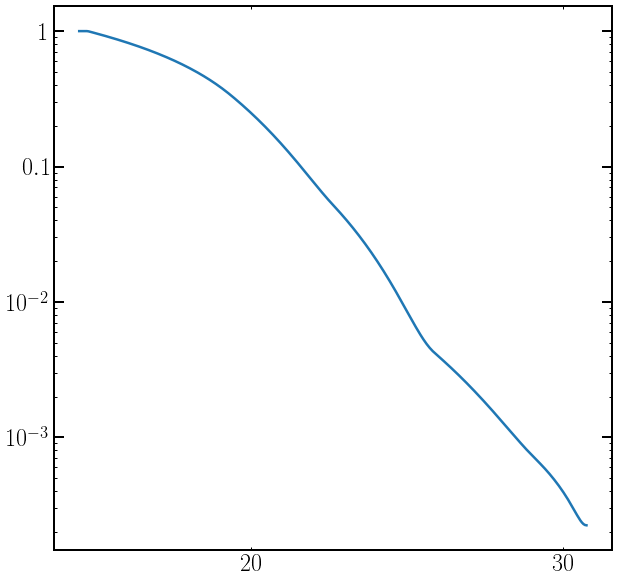

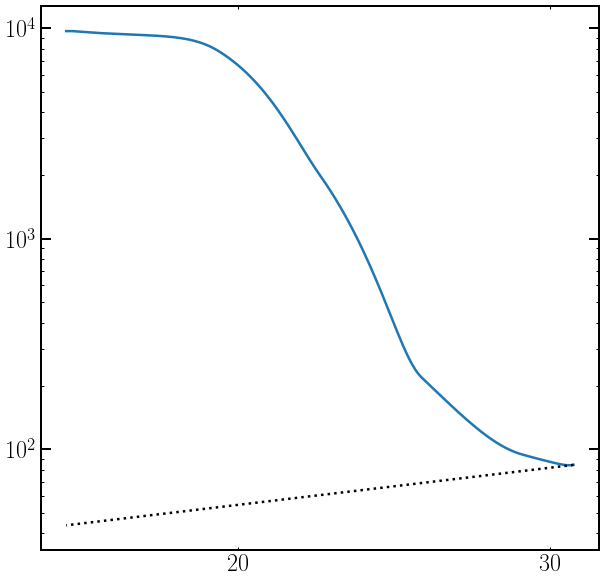

In [14]:
plt.figure()
# plt.plot(a[3].rs, a[0])
plt.plot(b[3].rs, b[0])
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


plt.figure()
# plt.plot(a[3].rs, a[1]/phys.kB)
plt.plot(b[3].rs, b[1]/phys.kB)
plt.plot(b[3].rs, phys.TCMB(b[3].rs)/phys.kB, 'k:')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')


In [15]:
a[0]
a[3].rs[1:]

NameError: name 'a' is not defined

In [ ]:
a = 2
str(a)